In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pycaret.classification import *

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from matplotlib.colors import ListedColormap


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pycaret.regression import *
from sklearn.metrics import silhouette_samples, silhouette_score
import math
import random
import matplotlib.ticker as mtick
import re

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error


from neighborhoods import admin_wards
from neighborhoods import district_neighborhoods

In [2]:
random.seed(42)

In [3]:
# Load the dataset
# df = pd.read_csv('../data/processed/additional_data_cluster_0.csv')
# df = pd.read_csv('../data/processed/additional_data_cluster_1.csv')
df = pd.read_csv('../data/processed/additional_data_cleaned_ER.csv')
df_unseen = pd.read_csv('../data/processed/scraped_data_cleaned_ER.csv')

df_unseen = df_unseen.sample(n=100, random_state=42)

df = df.dropna()
df.shape

(11322, 15)

In [4]:
df['price'] = df['price'].apply(lambda x: np.log(x))
df_unseen['price'] = df_unseen['price'].apply(lambda x: np.log(x))

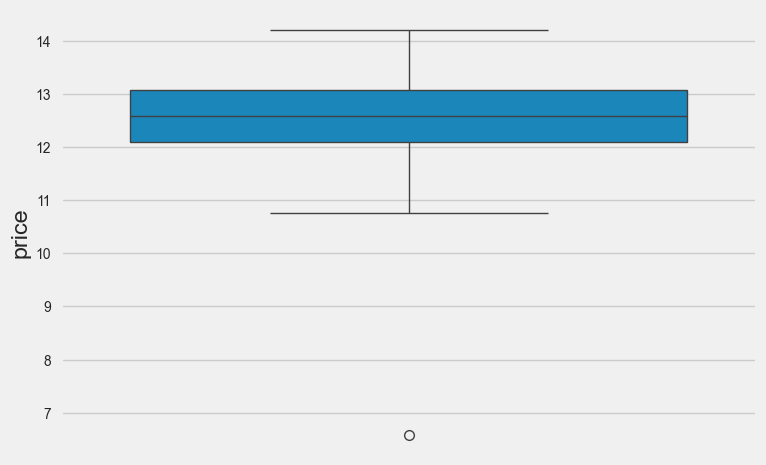

In [5]:
sns.boxplot(df['price'])
plt.show()

In [6]:
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [7]:
df = drop_outliers_iqr(df, 'price')
df_unseen = drop_outliers_iqr(df_unseen, 'price')

In [8]:
df.describe()

,price,rooms,m2,elevator,garage,sports_centers,social_wellness_index,urban_mobility_index,education_index,employment_index,health_index
count,11321.000000,11321.000000,11321.000000,11321.000000,11321.000000,11321.000000,11321.000000,11321.000000,11321.000000,11321.000000,11321.000000
mean,12.617095,2.450579,89.757707,0.702676,0.240261,0.590231,7.505077,8.715121,7.739540,7.947143,7.223017
std,0.635252,0.895444,35.517512,0.457100,0.427261,0.758234,1.804855,6.389772,2.896884,2.870125,1.543894
min,10.768485,1.000000,20.000000,0.000000,0.000000,0.000000,4.840000,3.060000,2.430000,3.810000,5.390000
25%,12.095141,2.000000,63.000000,0.000000,0.000000,0.000000,6.040000,5.460000,5.250000,5.420000,6.190000
50%,12.577636,2.000000,83.000000,1.000000,0.000000,0.000000,7.130000,6.780000,6.810000,7.670000,6.970000
75%,13.081541,3.000000,112.000000,1.000000,0.000000,1.000000,8.580000,9.240000,10.640000,10.080000,7.530000
max,14.207553,4.000000,195.000000,1.000000,1.000000,5.000000,13.040000,56.340000,14.080000,17.500000,18.950000


In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [11]:
df_corr = pd.DataFrame(df[numerical_features].corr()['price'])
df_corr['price'] = df_corr['price'].apply(lambda x: abs(x))
df_corr.sort_values(by='price', ascending=False)

,price
price,1.000000
m2,0.732068
employment_index,0.631651
education_index,0.558361
elevator,0.522182
rooms,0.305280
garage,0.290729
social_wellness_index,0.236830
urban_mobility_index,0.231960
sports_centers,0.076396


In [12]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [13]:
# Define features and target variable
X = df[[column for column in df.columns if column != 'price']]
y = df['price']

In [14]:
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [15]:
# Setup the environment in PyCaret
regression_setup = setup(
    data=df,
    target = 'price',
    ignore_features=[],
    numeric_imputation = 'mean',
    categorical_imputation = 'mode',
    remove_multicollinearity=True,
    transformation= True,
    transformation_method = 'yeo-johnson',
    normalize = True,
    normalize_method = 'zscore',
    session_id=42,
)

,Description,Value
0,Session id,42
1,Target,price
2,Target type,Regression
3,Original data shape,"(11321, 15)"
4,Transformed data shape,"(11321, 35)"
5,Transformed train set shape,"(7924, 35)"
6,Transformed test set shape,"(3397, 35)"
7,Numeric features,10
8,Categorical features,4
9,Preprocess,True


In [16]:
n_iter=50

# print('Tune Model:')
# best_model = tune_model(best_model, n_iter=n_iter, choose_better=True)

# print('Tune Model - optuna:')
# best_model = tune_model(best_model, search_library = 'optuna', n_iter=n_iter, choose_better=True)

# print('Tune Model - scikit-optimize:')
# best_model = tune_model(best_model, search_library = 'scikit-optimize', n_iter=n_iter, choose_better=True)

# print('Bagging:')
# best_model = ensemble_model(best_model, method = 'Bagging', choose_better=True)

# print('Boosting:')
# best_model = ensemble_model(best_model, method = 'Boosting', choose_better=True)

print('Top 3 Models:')
best_mae_models_top3 = compare_models(sort = 'MAE', n_select = 3, exclude=['lar', 'lr'])

# print('Blending:')
# best_model = blend_models(best_mae_models_top3, choose_better=True)

print('Stacking:')
best_model = stack_models(best_mae_models_top3, choose_better=True)

Top 3 Models:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.1477,0.0386,0.1963,0.9049,0.0145,0.0117,0.2710
lightgbm,Light Gradient Boosting Machine,0.1514,0.0404,0.2008,0.9004,0.0148,0.0120,0.6400
rf,Random Forest Regressor,0.1538,0.0429,0.2071,0.8941,0.0153,0.0122,0.3110
xgboost,Extreme Gradient Boosting,0.1545,0.0420,0.2047,0.8964,0.0151,0.0123,0.0570
et,Extra Trees Regressor,0.1550,0.0449,0.2118,0.8892,0.0156,0.0123,0.2730
gbr,Gradient Boosting Regressor,0.1635,0.0463,0.2150,0.8859,0.0158,0.0130,0.1070
huber,Huber Regressor,0.1689,0.0496,0.2227,0.8776,0.0164,0.0134,0.0450
br,Bayesian Ridge,0.1693,0.0495,0.2225,0.8778,0.0164,0.0135,0.0440
ridge,Ridge Regression,0.1693,0.0495,0.2225,0.8778,0.0164,0.0135,0.1670
knn,K Neighbors Regressor,0.1838,0.0591,0.2430,0.8542,0.0179,0.0146,0.0420


Stacking:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1438,0.0354,0.1882,0.9106,0.0140,0.0115
1,0.1520,0.0406,0.2015,0.8998,0.0148,0.0120
2,0.1451,0.0375,0.1938,0.8994,0.0143,0.0115
3,0.1460,0.0372,0.1929,0.9103,0.0142,0.0116
4,0.1368,0.0346,0.1861,0.9141,0.0137,0.0108
5,0.1523,0.0406,0.2015,0.9051,0.0148,0.0121
6,0.1481,0.0390,0.1976,0.9039,0.0145,0.0118
7,0.1444,0.0348,0.1866,0.9130,0.0137,0.0115
8,0.1465,0.0420,0.2050,0.8998,0.0151,0.0116


In [17]:
holdout_pred = predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.1435,0.0365,0.1910,0.9084,0.0141,0.0114


In [18]:
holdout_pred['price'] = np.exp(holdout_pred['price'])
holdout_pred['prediction_label'] = np.exp(holdout_pred['prediction_label'])
mae = mean_absolute_error(holdout_pred['price'], holdout_pred['prediction_label'])
rmse = np.sqrt(mean_squared_error(holdout_pred['price'], holdout_pred['prediction_label']))
rmse, mae

(85398.05146259312, 53487.70494467616)

In [19]:
holdout_pred.describe()

,rooms,m2,elevator,garage,sports_centers,social_wellness_index,urban_mobility_index,education_index,employment_index,health_index,price,prediction_label
count,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000,3397.000000,3.397000e+03,3.397000e+03
mean,2.457462,89.538414,0.702090,0.240801,0.580512,7.499041,8.885581,7.712676,7.930531,7.212214,3.705700e+05,3.642540e+05
std,0.895464,35.363964,0.457407,0.427633,0.740323,1.797685,6.640192,2.876897,2.842995,1.526298,2.535906e+05,2.350486e+05
min,1.000000,21.000000,0.000000,0.000000,0.000000,4.840000,3.060000,2.430000,3.810000,5.390000,5.600002e+04,6.228293e+04
25%,2.000000,63.000000,0.000000,0.000000,0.000000,6.040000,5.460000,5.150000,5.420000,6.180000,1.790001e+05,1.824563e+05
50%,3.000000,83.000000,1.000000,0.000000,0.000000,7.130000,6.810000,6.810000,7.620000,6.970000,2.899999e+05,2.872292e+05
75%,3.000000,111.000000,1.000000,0.000000,1.000000,8.560000,9.240000,10.580000,9.990000,7.530000,4.749998e+05,4.812873e+05
max,4.000000,195.000000,1.000000,1.000000,5.000000,13.040000,56.340000,14.080000,17.500000,18.950001,1.470000e+06,1.415226e+06


In [20]:
RMSE = np.sqrt(mean_squared_error(holdout_pred['price'], holdout_pred['prediction_label']))
RMSE/(holdout_pred['price'].max() - holdout_pred['price'].min())

0.060394646555940734

In [21]:
unseen_predictions = predict_model(best_model, data=df_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.3722,0.2327,0.4824,0.6888,0.0318,0.0263


In [22]:
unseen_predictions['price'] = np.exp(unseen_predictions['price'])
unseen_predictions['prediction_label'] = np.exp(unseen_predictions['prediction_label'])
mae = mean_absolute_error(unseen_predictions['price'], unseen_predictions['prediction_label'])
rmse = np.sqrt(mean_squared_error(unseen_predictions['price'], unseen_predictions['prediction_label']))
rmse, mae

(1026622.6192826637, 509608.11440463574)

In [23]:
RMSE = np.sqrt(mean_squared_error(unseen_predictions['price'], unseen_predictions['prediction_label']))
RMSE/(unseen_predictions['price'].max() - unseen_predictions['price'].min())

0.13255130070237803

In [24]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

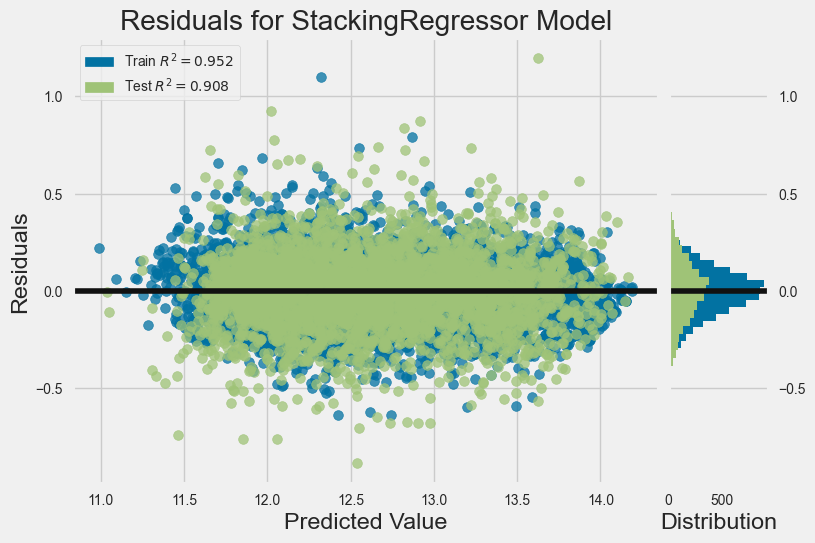

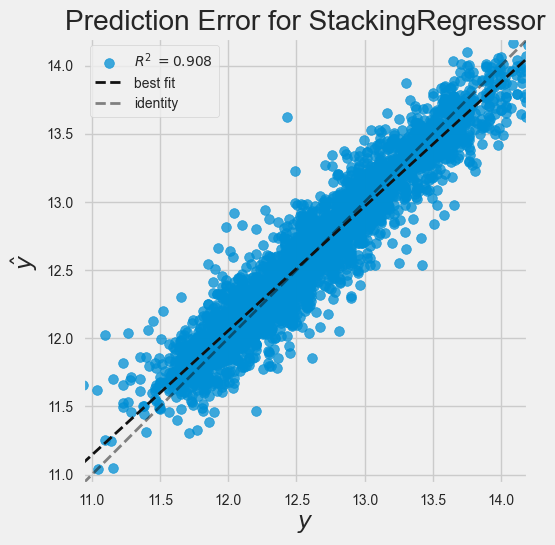

In [25]:
plot_model(best_model, plot = 'residuals', fold=10)

plot_model(best_model, plot = 'error')

# plot_model(best_model, plot = 'feature')

# plot_model(best_model, plot = 'learning')

<Axes: >

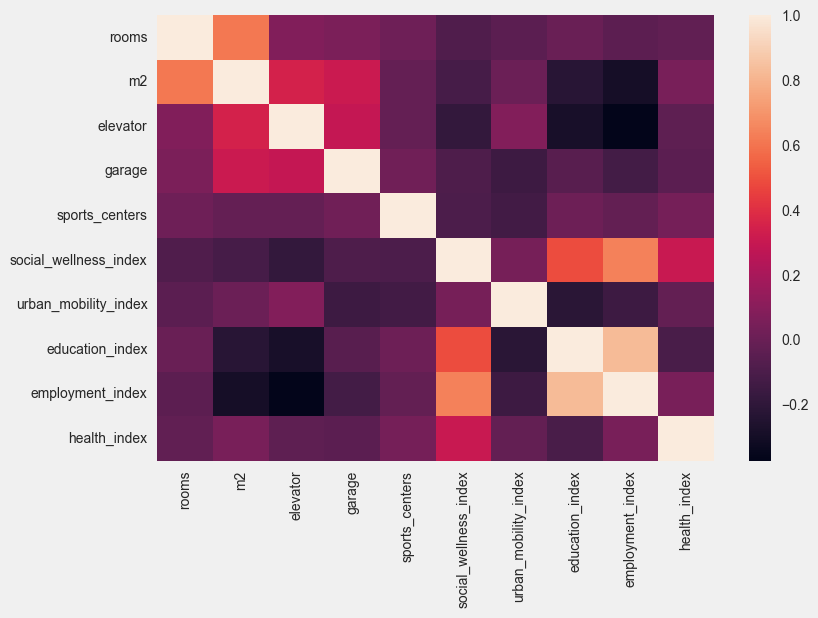

In [26]:
sns.heatmap(df[numerical_features].corr())